In [1]:
from torchview import draw_graph
import graphviz
from torch import nn
import torch

# when running on vscode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

The purpose of this notebook is to introduce API and notation of torchview package with common use cases.

We start with simple MLP model

In [2]:
class MLP(nn.Module):
    """Multi Layer Perceptron with inplace option.
    Make sure inplace=true and false has the same visual graph"""

    def __init__(self, inplace: bool = True) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(inplace),
            nn.Linear(128, 128),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

In [3]:
model_graph_1 = draw_graph(
    MLP(), input_size=(2, 128),
    graph_name='MLP',
    hide_inner_tensors=False,
    hide_module_functions=False,
)

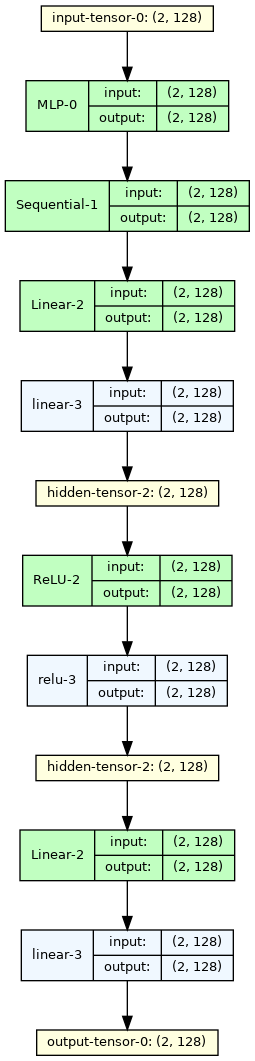

In [4]:
model_graph_1.visual_graph

Any visual graph representation of pytorch models provided by torchview package consists of nodes and directed edges (maybe also undirected ones for future releases).
Each node is connected by an edge that indicates information flow in the neural network.

There are 3 types of nodes:

* Tensor Node
* Function Node
* Module Node


1) Tensor Node: This node is represented by bright yellow color. It has the label is of the form `{tensor-name}{depth}: {tensor-shape}`. `tensor-name` can take 3 values input-tensor, hidden-tensor, or output-tensor. Depth is the depth of tensor in hierarchy of modules.

2) Function Node: This node is represented by bright blue color. Its label is of the form `{Function-name}{depth}: {input and output shape}`.

3) Module Node: This node is represented by bright green color. Its label is of the form `{Module-name}{depth}: {input and output shape}`.

In the example of MLP above, input tensor is called by main module MLP. This input tensor is called by its submodules, Sequential. Then, it is called by its submodule linear. Now, inside linear module exists linear function `F.linear`. This finally applied to input-tensor and returns output-tensor. This is sent to ReLU layer and so on.

Now, we show how rolling mechanism on recursive modules implemented. To demonstrate this, we use RNN module

In [5]:
class SimpleRNN(nn.Module):
    """Simple RNN"""

    def __init__(self, inplace: bool = True) -> None:
        super().__init__()
        self.hid_dim = 2
        self.input_dim = 3
        self.max_length = 4
        self.lstm = nn.LSTMCell(self.input_dim, self.hid_dim)
        self.activation = nn.LeakyReLU(inplace=inplace)
        self.projection = nn.Linear(self.hid_dim, self.input_dim)

    def forward(self, token_embedding: torch.Tensor) -> torch.Tensor:
        b_size = token_embedding.size()[0]
        hx = torch.randn(b_size, self.hid_dim, device=token_embedding.device)
        cx = torch.randn(b_size, self.hid_dim, device=token_embedding.device)

        for _ in range(self.max_length):
            hx, cx = self.lstm(token_embedding, (hx, cx))
            hx = self.activation(hx)

        return hx

In [6]:
model_graph_2 = draw_graph(
    SimpleRNN(), input_size=(2, 3),
    graph_name='RecursiveNet',
    roll=True
)

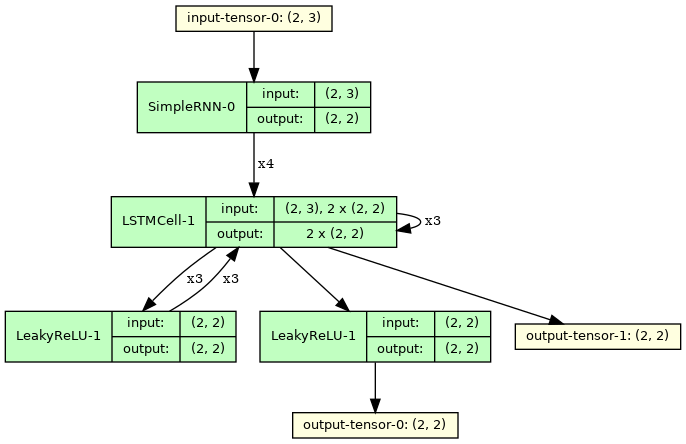

In [7]:
model_graph_2.visual_graph

In the graph above, we see a rolled representation of RNN with LSTM units. We see that LSTMCell and LeakyReLU nodes. This is representated by the numbers show on edges. These number near edges represent the number of edges that occur in `forward prop`. For instance, the first number 4 represent the number of times token_embedding is used.

If the number of times that edge is used is 1, then it is not shown.

Another useful feature is the resize feature. Say, the previous image of RNN is too big for your purpose. What we can do is to use resize feature rescale it by 0.5

In [8]:
model_graph_2.resize_graph(scale=0.5)

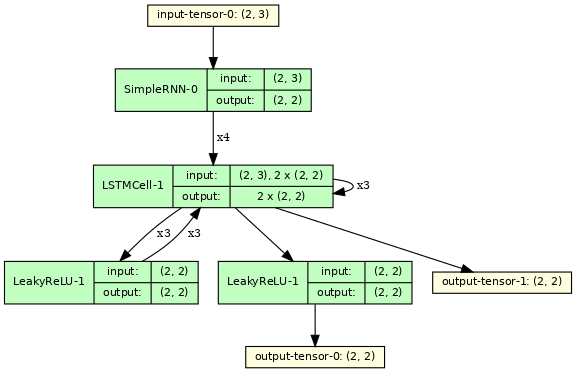

In [9]:
model_graph_2.visual_graph

It got smaller !!!